In [1]:
import dynet as dy
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import simple_nns as sn

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2  # ensures seamless reload of any changed module

In [3]:
seaborn.set()

### Gaining (provisional) understanding of an MLP layer
I was intrigued by some questions regarding MLP's and their application to classification problems.
1. Why is it a common practice to use large (50+) vectors in MLP hidden layers? aren't smaller spaces enough for classification, especially when the number of output classes is smaller (2-5)?
1. How to tell if the dimension I chose in my MLP design for the hidden layer(s) is too big or too small? 
1. In a multi-layer MLP, Can the successive application of linear and nonlinear 'activations' be made better understood?
1. How to tell if the MLP converged to a "reasonable" solution given the training set?
1. Keeping a "dev" set of labeled data that is not used for training is not always practical (when the size of labeled data set is barely enough for effective training). Are there other ways to examine (and control) the generality of the resulting model?
1. regularization - what is the correct approach to adding regularization terms?
1. Is there an alternative training process to SGD, even a much less efficient one, that can be used to validate an SGD training result?

While none of these questions is likely to get a comprehensive answer in the next 2-3 years, advancing towards such answers will be greatly appreciated by many practitioners.


for gaining better understanding we will start with the simplest possible form of the classification MLP: a single layer MLP taking 2-D input and yielding 2-D output.
Further, we will replace the most common loss function (cross entropy, aka neg-log) and the most common activations (tanh/ sigmoid/ 
avoid both the softmax and the tanh, and replace them with 
need a simplified, more workable model of the 

In [5]:
specs = [
    sn.patch_train_data.patch_spec(unit_circle(20*np.pi/180)*0.4,0.02, 30, 0),
    sn.patch_train_data.patch_spec(unit_circle(50*np.pi/180)*0.4,0.02, 30, 1)
]

train_2patch = sn.patch_train_data(specs)
del specs

In [81]:
def demonstrate_convergence(train, k=7, g=3, with_bias=False, epochs_per_plot = 50):
    assert(k <= g*g)
    #plt.subplots(1, k)
    plt.figure(figsize=(20,20))
    plt.subplot(g,g,1)
    n1 = sn.single_layer(with_bias = with_bias)
    train.plot()
    n1.plot_2d_layer()

    for i in range(2,k+1):
        n1.train_network(train.data(), epochs_per_plot)
        plt.subplot(g,g,i)
        train.plot()
        n1.plot_2d_layer()


    x_p = n1.eval_list(train.data_x)
    transformed_train_data = sn.train_data(x_p, train.data_y)
    ax = plt.subplot(g,g,k+1)
    ax.set_title('Transformed sample')
    transformed_train_data.plot()
    


### convergence without a bias term

The axes plotted below are not $W$ rows but rather $W^{-1}$ columns.

These more intuitively represent the coordinate of each point after the transform.

#### initialization of $W$ and $b$: 
* The default init. of $W$ and $b$ may result in values $ >> 1$ in their entries
* Since the $\textrm{dReLU}$ function has zero gradient outside $\pm1$, The sample coordinates would (partially or fully) fall in the zero gradient zone.
* This would make SGD progress in the correct direction very hard.
* using a uniform-probability initialization that ensured $|W| \lt 1$, $|b| \lt 1$ solved this issue

#### visualization of the final coordinates
* The final axes represent the output coordinates of the train sample.
* Since we "encouraged" blue dots to be transformed to $(1,0)$ and red dots to $(0,1)$, this chart is a very good illustration of the quality of the result.



average loss: 0.589400893867 acc: 0.532333333333
average loss: 0.30286747473 acc: 1.0
average loss: 0.15366919621 acc: 1.0
average loss: 0.0617680972939 acc: 1.0
average loss: 0.0181857418649 acc: 1.0
average loss: 0.00519779540731 acc: 1.0


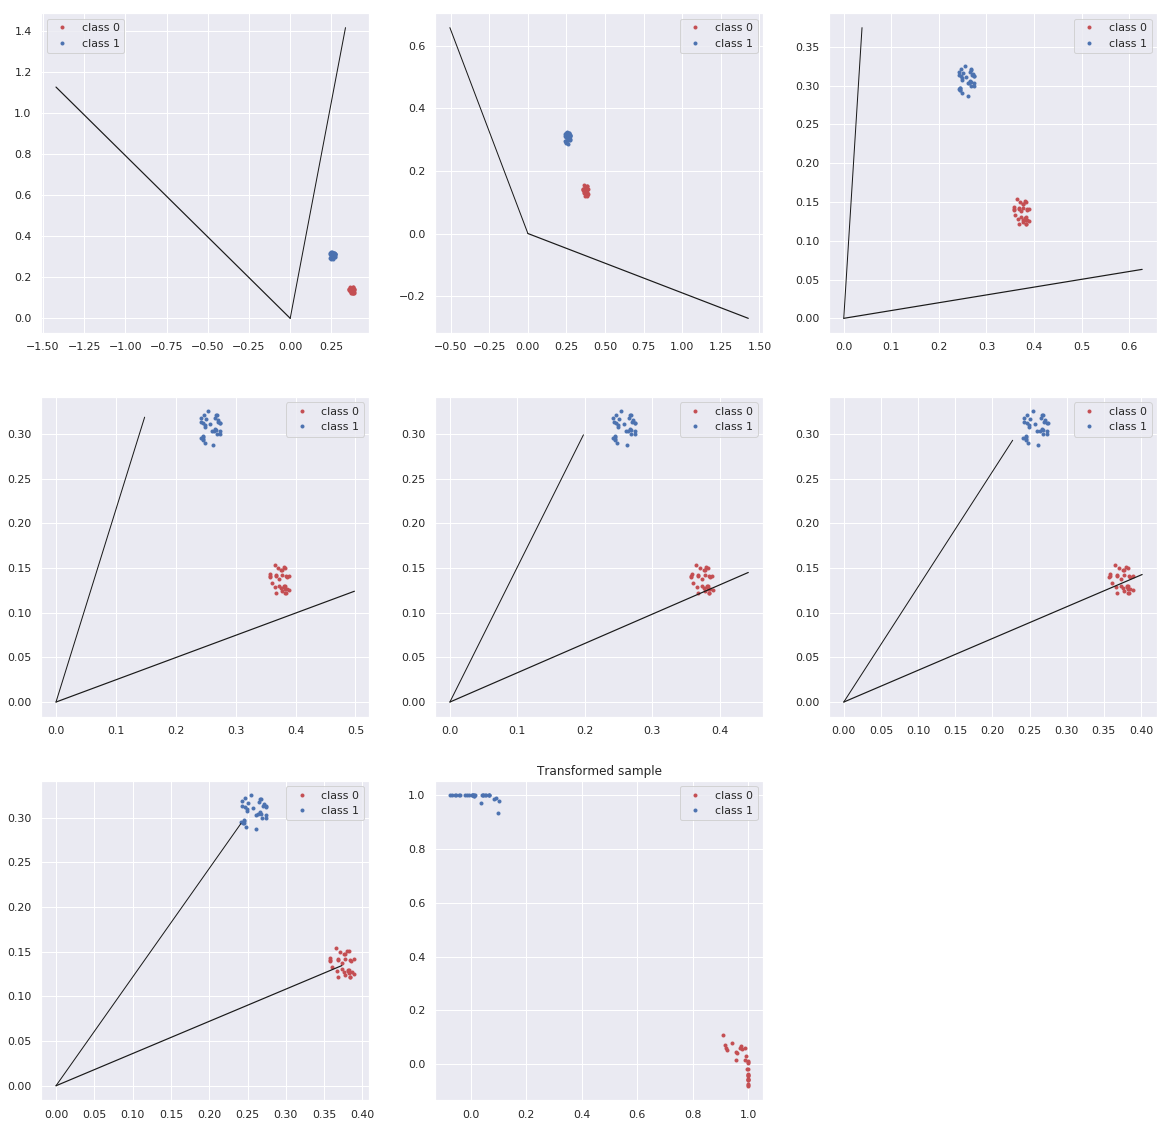

In [82]:
demonstrate_convergence(train, 7, 3, False)

### convergence in the presence of a bias term
* The bias term was added as $$output = \textrm{dReLU}(W \cdot (x + b))$$

* This formulation has more free parameters than necessary, since a suitable $W$ can be found for almost any choice of $b$
    * indeed this seems to converge slower than the bias-less formulation

* The fact that $b$ is *inside* the parentheses (and therfore multiplied by $W$ together with $x$) makes the layer's transformation effect more intuitive:
    * We first _shift_ the coordinates by $b$ 
    * then apply $W$ - which may rotate, scale and shear them. 

* It is easy to see the equivalence with the common formulation $W \cdot x + b'$ via $b'= W^{-1}b$.

    * However this doesn't holds when $W$ is not [well-conditioned](https://en.wikipedia.org/wiki/Condition_number#Matrices)

* Also note that if W were not square, this formulation would require $b$ to have the dimension of the output of the *previous* layer, not the current one.

* Interesting further questions:
    * Which formulation ($b$ or $b'$) is advantageous when $W$ happens to be close to singular?
    * Which formulation has better convergence characteristics? Does the fact that the linear transformation is decoupled from the translation improve or hinder convergence?




average loss: 0.544059879233 acc: 0.683333333333
average loss: 0.308966459428 acc: 1.0
average loss: 0.200743988854 acc: 1.0
average loss: 0.124948007933 acc: 1.0
average loss: 0.0728911815509 acc: 1.0
average loss: 0.0397114663916 acc: 1.0


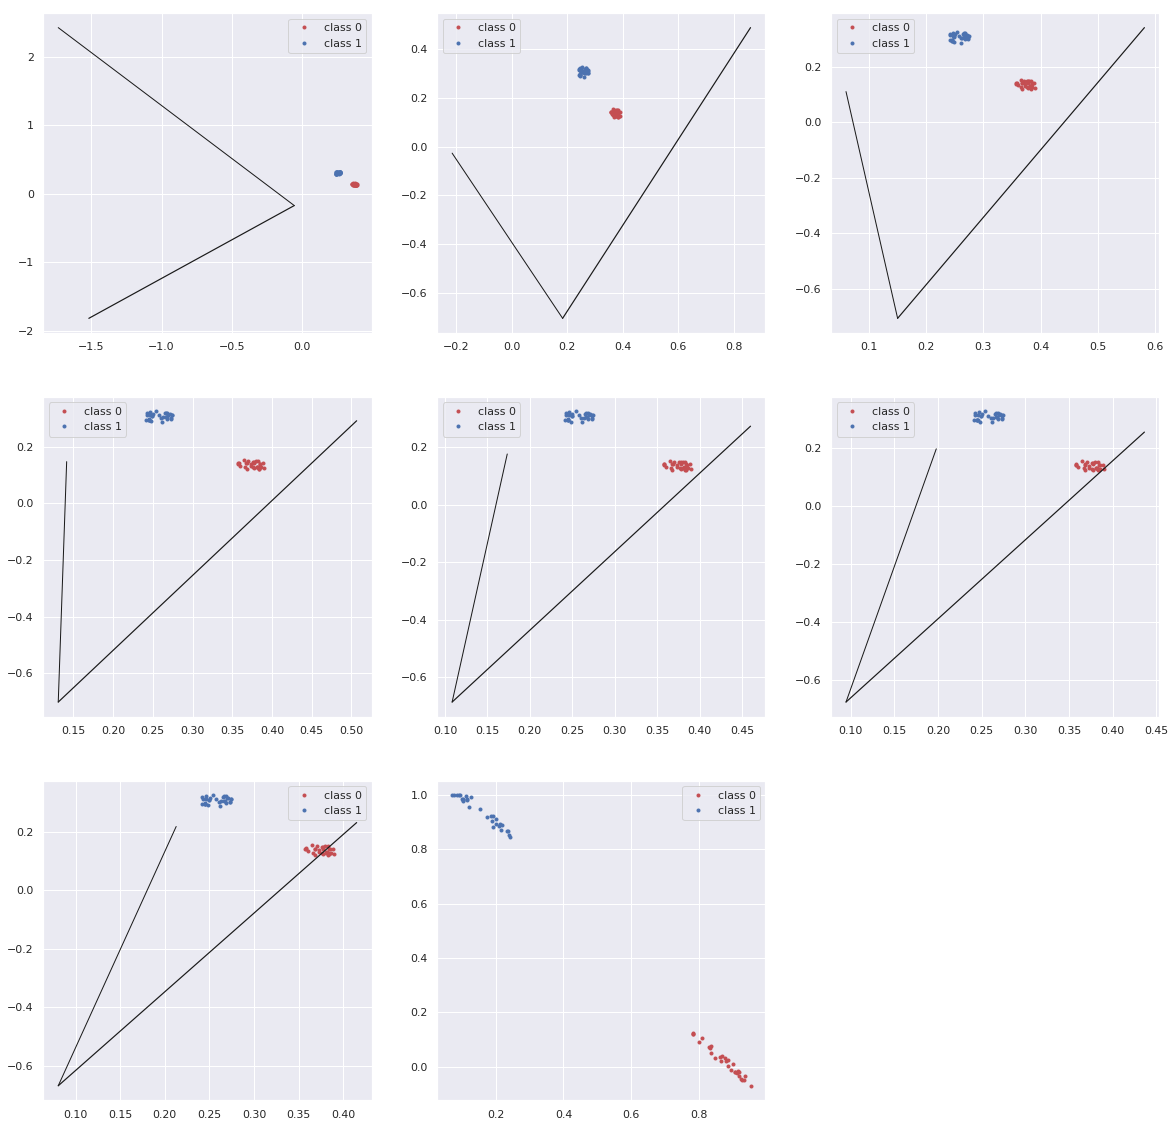

In [75]:
demonstrate_convergence(train, 7, 3, True)

average loss: 0.515585909893 acc: 0.825333333333
average loss: 0.373813433041 acc: 0.999666666667
average loss: 0.262934536239 acc: 1.0
average loss: 0.121023408981 acc: 1.0
average loss: 0.023491799915 acc: 1.0
average loss: 0.00502785415302 acc: 1.0


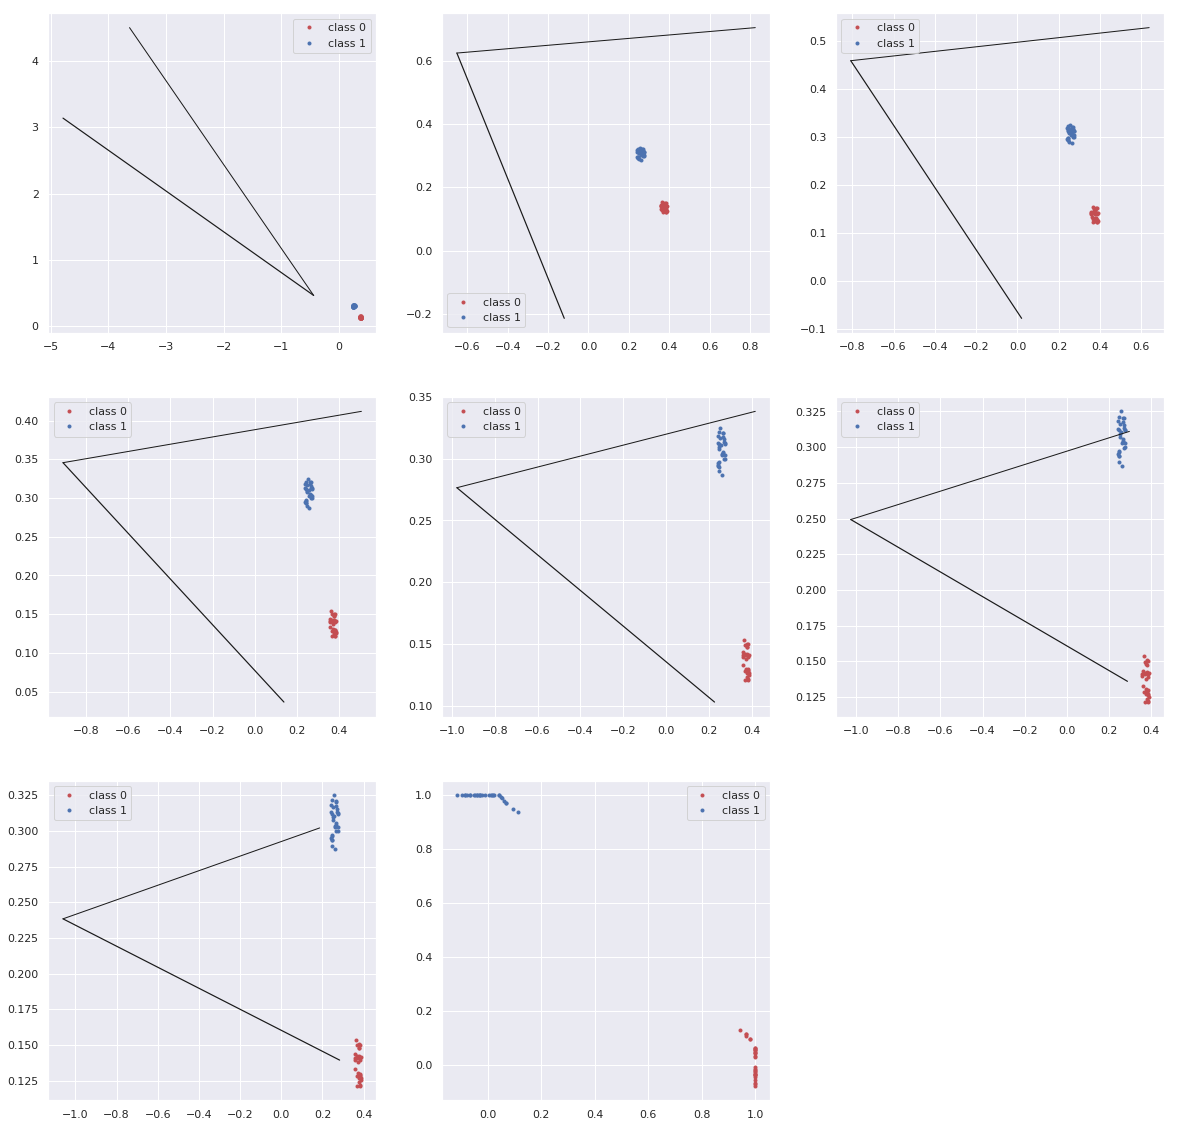

In [76]:
demonstrate_convergence(train, 7, 3, True)

### using the bias term to solve "colinearity"
* Colinearity for our patch (clustered) training data means that more than 2 patches are on the same straight line
* if the extreme patches are of different classes, then 100% accuracy can still be obtained by placing the origin outside the straight line
* to examine the ability of the MLP to overcome this issue, we will initate $b$ with zeros

In [68]:
w = n1.params["W"][0].npvalue()
print w
print
print np.linalg.inv(w)

[[ 3.86064792 -3.19274807]
 [-1.72133708  4.80232286]]

[[0.3681554  0.24476227]
 [0.13196104 0.29596477]]


In [67]:
w.dot(np.array([0.25, 0.3]))

array([0.00733756, 1.01036259])